In [8]:
import pandas as pd
import numpy as np
import requests
import xgboost
from urllib import parse
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, Activation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('학습셋_A트랙/A Track 학습셋.csv')
data['decoded_payload'] = data['payload'].apply(lambda x: parse.unquote(x))

In [3]:
max_length = max(len(payload) for payload in data['decoded_payload'])
total_length = sum(len(payload) for payload in data['decoded_payload'])
average_length = total_length / len(data['decoded_payload'])
print("최대길이 : ", max_length)
print("평균길이 : ", average_length)

최대길이 :  7127
평균길이 :  510.6442222222222


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data['decoded_payload'], data['label_action'], stratify = data['label_action'], 
                                                    test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.3, analyzer='char', sublinear_tf=True, ngram_range=(1,3), max_features=max_length)
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# 분할된 데이터프레임의 인덱스를 초기화합니다.
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(X_train_transformed.shape, X_test_transformed.shape)

# X_train_transformed을 DataFrame으로 변환
X_train_df = pd.DataFrame(X_train_transformed.toarray())

# X_test_transformed을 DataFrame으로 변환
X_test_df = pd.DataFrame(X_test_transformed.toarray())

(36000, 3486) (9000, 3486)


In [7]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model = Sequential()
model.add(Dense(64, input_shape=(X_train_df.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_df, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


2023-10-18 16:27:07.519363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


896/900 [============================>.] - ETA: 0s - loss: 0.5540 - accuracy: 0.7950

2023-10-18 16:27:13.852785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


900/900 [==============================] - 8s 7ms/step - loss: 0.5529 - accuracy: 0.7955 - val_loss: 0.4020 - val_accuracy: 0.8379
Epoch 2/10
900/900 [==============================] - 6s 6ms/step - loss: 0.3855 - accuracy: 0.8458 - val_loss: 0.3917 - val_accuracy: 0.8456
Epoch 3/10
900/900 [==============================] - 6s 7ms/step - loss: 0.3580 - accuracy: 0.8562 - val_loss: 0.3795 - val_accuracy: 0.8447
Epoch 4/10
900/900 [==============================] - 6s 6ms/step - loss: 0.3401 - accuracy: 0.8629 - val_loss: 0.3697 - val_accuracy: 0.8551
Epoch 5/10
900/900 [==============================] - 6s 6ms/step - loss: 0.3313 - accuracy: 0.8650 - val_loss: 0.3660 - val_accuracy: 0.8574
Epoch 6/10
900/900 [==============================] - 6s 6ms/step - loss: 0.3257 - accuracy: 0.8678 - val_loss: 0.3598 - val_accuracy: 0.8667
Epoch 7/10
900/900 [==============================] - 6s 6ms/step - loss: 0.3199 - accuracy: 0.8719 - val_loss: 0.3702 - val_accuracy: 0.8560
Epoch 8/10
900/90

In [34]:
y_pred = model.predict(X_test_df)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print("Accuracy:", accuracy)
print("classification_report:\n", classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

282/282 [==============================] - 1s 2ms/step
Accuracy: 0.8673333333333333
classification_report:
                                precision    recall  f1-score   support

Automatically_Searching_Infor       0.99      1.00      1.00       224
         Cross_Site_Scripting       0.83      0.87      0.85       270
           Directory_Indexing       0.93      0.98      0.95        84
                    HOST_Scan       0.88      0.81      0.84      1263
           Leakage_Through_NW       1.00      0.99      1.00       191
              Path_Disclosure       0.88      0.86      0.87       955
                SQL_Injection       0.95      0.87      0.91       679
         System_Cmd_Execution       0.84      0.81      0.83      1961
           Vulnerability_Scan       0.85      0.90      0.87      3373

                     accuracy                           0.87      9000
                    macro avg       0.90      0.90      0.90      9000
                 weighted avg       0.

In [4]:
def create_feature_length(payloads):
  payloads['length'] = [len(str(row)) for row in payloads['decoded_payload'] ]
  return payloads

def create_feature_nonprintable(payloads):
  payloads['non-printable'] = [len([1 for letter in str(row) if letter not in string.printable]) for row in payloads['decoded_payload']]
  return payloads

def create_feature_punchualchar(payloads):
  payloads['punctuation'] = [len([1 for letter in str(row) if letter in string.punctuation])  for row in payloads['decoded_payload']]
  return payloads

def create_feature_minbyte(payloads):
  payloads['min-byte'] = [min(bytearray(str(row),'utf-8')) for row in payloads['decoded_payload']]
  return payloads

def create_feature_maxbyte(payloads):
  payloads['max-byte'] = [max(bytearray(str(row),'utf-8')) for row in payloads['decoded_payload']]
  return payloads

def create_feature_meanbyte(payloads):
  payloads['mean-byte'] = [np.mean(bytearray(str(row),'utf-8')) for row in payloads['decoded_payload']]
  return payloads

def create_feature_stdbyte(payloads):
  payloads['std-byte'] = [np.std(bytearray(str(row),'utf-8')) for row in payloads['decoded_payload']]
  return payloads

def create_feature_dstbyte(payloads):
  payloads['distinct-byte'] = [len(set(bytearray(str(row),'utf-8'))) for row in payloads['decoded_payload']]
  return payloads

sql_keywords = pd.read_csv('https://trello-attachments.s3.amazonaws.com/5ed2d4107c349c221194b608/5ed2d453f0e5a45bcd8cf16c/435e639346787ce2b495a16e9f690ef5/SQLKeywords.txt', index_col=False)

def create_feature_sql_keywords(payloads):
  payloads['sql-keywords'] = [ len([1 for keyword in sql_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in payloads['decoded_payload']]
  return payloads
  
js_keywords = pd.read_csv("https://trello-attachments.s3.amazonaws.com/5ed2d4107c349c221194b608/5ed2d453f0e5a45bcd8cf16c/dedc7eb9846a30c252cd950a0e2153d9/JavascriptKeywords.txt",index_col=False)
def create_feature_javascript_keywords(payloads):
  payloads['js-keywords'] = [len([1 for keyword in js_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in payloads['decoded_payload']]
  return payloads

data = create_feature_length(data)
data = create_feature_nonprintable(data)
data = create_feature_punchualchar(data)
data = create_feature_minbyte(data)
data = create_feature_maxbyte(data)
data = create_feature_meanbyte(data)
data = create_feature_stdbyte(data)
data = create_feature_dstbyte(data)
data = create_feature_sql_keywords(data)
data = create_feature_javascript_keywords(data)
custom_data = data.drop(['payload', 'decoded_payload', 'Log_Number'], axis=1)
custom_data.head()

,label_action,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-byte,sql-keywords,js-keywords
0,System_Cmd_Execution,480,0,132,32,124,88.239583,27.382379,70,11,6
1,System_Cmd_Execution,619,0,143,32,124,83.505654,28.499999,69,14,7
2,SQL_Injection,752,0,146,32,122,89.618351,25.340644,75,6,2
3,HOST_Scan,22,0,7,32,114,75.545455,25.610238,12,0,0
4,System_Cmd_Execution,368,0,82,32,122,79.320652,27.791937,64,9,5


In [23]:
def learning_curve(history, epoch):
  plt.figure(figsize = (10,5))
  epoch_range = np.arange(1, epoch + 1)

  plt.subplot(1, 2, 1)

  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Val'])

  plt.subplot(1,2,2)

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train', 'Val'])
  plt.show()

In [5]:
from pycaret.classification import *

X_train, X_test, y_train, y_test = train_test_split(custom_data, custom_data['label_action'], stratify = custom_data['label_action'], 
                                                    test_size=0.2, random_state=42)

In [6]:
X_train.drop(columns=['label_action'], inplace=True)
X_test.drop(columns=['label_action'], inplace=True)

In [16]:
clf = setup(data=custom_data, target = 'label_action', session_id=2023, fold=5, n_jobs=-1, normalize=True, transformation=True)

,Description,Value
0,Session id,2023
1,Target,label_action
2,Target type,Multiclass
3,Target mapping,"Automatically_Searching_Infor: 0, Cross_Site_Scripting: 1, Directory_Indexing: 2, HOST_Scan: 3, Leakage_Through_NW: 4, Path_Disclosure: 5, SQL_Injection: 6, System_Cmd_Execution: 7, Vulnerability_Scan: 8"
4,Original data shape,"(45000, 11)"
5,Transformed data shape,"(45000, 11)"
6,Transformed train set shape,"(31499, 11)"
7,Transformed test set shape,"(13501, 11)"
8,Numeric features,10
9,Preprocess,True


In [17]:
rf_model = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8227,0.9663,0.8227,0.8234,0.8228,0.7701,0.7701
1,0.8179,0.9664,0.8179,0.8177,0.8175,0.7633,0.7635
2,0.8254,0.9682,0.8254,0.8266,0.8257,0.7736,0.7737
3,0.8241,0.9678,0.8241,0.8243,0.8238,0.7712,0.7714
4,0.8190,0.9652,0.8190,0.8197,0.8192,0.7653,0.7653
Mean,0.8218,0.9668,0.8218,0.8223,0.8218,0.7687,0.7688
Std,0.0029,0.0011,0.0029,0.0032,0.0030,0.0038,0.0038


In [18]:
predict_model(rf_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8282,0.9675,0.8282,0.8290,0.8284,0.7773,0.7774


,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-byte,sql-keywords,js-keywords,label_action,prediction_label,prediction_score
35145,519,0,94,32,122,85.888245,27.790142,71,18,7,6,SQL_Injection,1.0000
43085,283,0,65,32,122,86.512367,28.668737,59,6,3,8,Path_Disclosure,0.5000
43825,479,1,87,0,122,84.578285,26.510597,71,3,2,8,Vulnerability_Scan,0.7700
1260,285,0,65,32,122,86.961403,28.762218,60,7,4,8,Path_Disclosure,0.6300
22711,563,0,102,32,122,85.445824,27.690149,69,16,9,6,SQL_Injection,0.9100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29503,784,0,193,32,125,87.114799,27.414097,69,6,11,1,Cross_Site_Scripting,0.9950
10227,607,0,123,32,125,90.028008,26.629204,69,9,7,7,System_Cmd_Execution,1.0000
14579,339,0,64,32,122,92.064896,25.928228,55,9,4,8,Vulnerability_Scan,1.0000
15255,1135,0,265,32,122,91.418503,24.419971,75,8,3,7,System_Cmd_Execution,0.7700


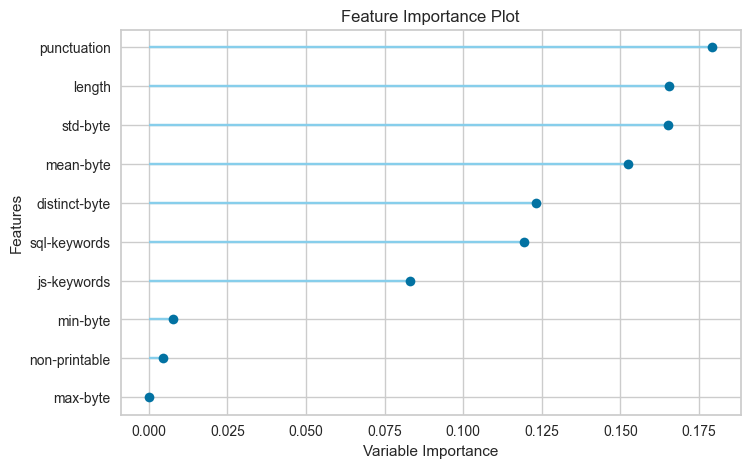

In [21]:
plot_model(rf_model, plot = 'feature')

In [5]:
merged_df = pd.concat([data[['Log_Number', 'payload', 'label_action', 'decoded_payload']], custom_data], axis=1)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(merged_df, merged_df['label_action'], stratify = merged_df['label_action'], 
                                                    test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=1, max_df=0.3, analyzer='char', sublinear_tf=True, ngram_range=(1,3), max_features=max_length)
X_train_transformed = vectorizer.fit_transform(X_train['decoded_payload'])
X_test_transformed = vectorizer.transform(X_test['decoded_payload'])

print(X_train_transformed.shape, X_test_transformed.shape)
# X_train_transformed을 DataFrame으로 변환
X_train_df = pd.DataFrame(X_train_transformed.toarray())

# X_test_transformed을 DataFrame으로 변환
X_test_df = pd.DataFrame(X_test_transformed.toarray())

(36000, 7127) (9000, 7127)


In [163]:
X_custom_train = X_train.drop(columns=['payload', 'decoded_payload', 'label_action', 'Log_Number'], axis=1)
X_custom_test = X_test.drop(columns=['payload', 'decoded_payload', 'label_action', 'Log_Number'], axis=1)

In [165]:
scaler = MinMaxScaler()
X_custom_train = pd.DataFrame(scaler.fit_transform(X_custom_train), columns=X_custom_train.columns)
X_custom_test = pd.DataFrame(scaler.transform(X_custom_test), columns=X_custom_test.columns)

In [167]:
X_train_df = pd.concat([X_train_df, X_custom_train.iloc[X_train_df.index]], axis=1)
X_test_df = pd.concat([X_test_df, X_custom_test.iloc[X_test_df.index]], axis=1)

### full data df 생성

In [6]:
y = data['label_action']

In [9]:
vectorizer = TfidfVectorizer(min_df=1, max_df=0.3, analyzer='char', sublinear_tf=True, ngram_range=(1,3), max_features=max_length)
data_transformed = vectorizer.fit_transform(data['decoded_payload'])

X_data_df = pd.DataFrame(data_transformed.toarray())
X_custom_data = data.drop(columns=['payload', 'decoded_payload', 'label_action', 'Log_Number'], axis=1)
scaler = MinMaxScaler()
X_custom_data = pd.DataFrame(scaler.fit_transform(X_custom_data), columns=X_custom_data.columns)
X_data_df = pd.concat([X_data_df, X_custom_data.iloc[X_data_df.index]], axis=1)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model = Sequential()
model.add(Dense(64, input_shape=(X_train_df.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(X_train_df, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2)

In [171]:
y_pred = model.predict(X_test_df)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print("Accuracy:", accuracy)
print("classification_report:\n", classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

 34/282 [==>...........................] - ETA: 0s

2023-10-20 11:07:02.962438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - 1s 3ms/step
Accuracy: 0.8756666666666667
classification_report:
                                precision    recall  f1-score   support

Automatically_Searching_Infor       0.99      1.00      0.99       224
         Cross_Site_Scripting       0.89      0.83      0.86       270
           Directory_Indexing       0.95      0.98      0.96        84
                    HOST_Scan       0.89      0.82      0.85      1263
           Leakage_Through_NW       1.00      1.00      1.00       191
              Path_Disclosure       0.92      0.86      0.89       955
                SQL_Injection       0.89      0.90      0.90       679
         System_Cmd_Execution       0.81      0.86      0.83      1961
           Vulnerability_Scan       0.88      0.89      0.89      3373

                     accuracy                           0.88      9000
                    macro avg       0.91      0.90      0.91      9000
                 weighted avg       0.

### full data train

In [21]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

tf.keras.backend.clear_session()

model = Sequential()
model.add(Dense(32, input_shape=(X_data_df.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                228416    
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [22]:
# 모델 체크포인트 설정
checkpoint = ModelCheckpoint('best_model.h5',  # 모델을 저장할 파일 이름
                             monitor='val_accuracy',  # 모니터링할 지표 (여기서는 검증 정확도)
                             save_best_only=True,  # 가장 좋은 모델만 저장
                             mode='max',  # 모니터링 지표의 최대화
                             verbose=1)  # 저장 메시지 표시


callbacks = [checkpoint]
history = model.fit(X_data_df, y_encoded, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/50


2023-10-20 14:13:17.226381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1124/1125 [============================>.] - ETA: 0s - loss: 0.6499 - accuracy: 0.7744

2023-10-20 14:13:34.829772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.83489, saving model to best_model.h5
1125/1125 [==============================] - 21s 15ms/step - loss: 0.6497 - accuracy: 0.7745 - val_loss: 0.4033 - val_accuracy: 0.8349
Epoch 2/50
  11/1125 [..............................] - ETA: 12s - loss: 0.4542 - accuracy: 0.8324

/opt/miniconda3/envs/tf_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1122/1125 [============================>.] - ETA: 0s - loss: 0.4218 - accuracy: 0.8395
Epoch 2: val_accuracy improved from 0.83489 to 0.86000, saving model to best_model.h5
1125/1125 [==============================] - 14s 12ms/step - loss: 0.4223 - accuracy: 0.8393 - val_loss: 0.3445 - val_accuracy: 0.8600
Epoch 3/50
1121/1125 [============================>.] - ETA: 0s - loss: 0.3665 - accuracy: 0.8572
Epoch 3: val_accuracy improved from 0.86000 to 0.86456, saving model to best_model.h5
1125/1125 [==============================] - 13s 12ms/step - loss: 0.3665 - accuracy: 0.8573 - val_loss: 0.3424 - val_accuracy: 0.8646
Epoch 4/50
1125/1125 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.8673
Epoch 4: val_accuracy did not improve from 0.86456
1125/1125 [==============================] - 14s 12ms/step - loss: 0.3403 - accuracy: 0.8673 - val_loss: 0.3280 - val_accuracy: 0.8613
Epoch 5/50
1124/1125 [============================>.] - ETA: 0s - loss: 0.3213 - accuracy

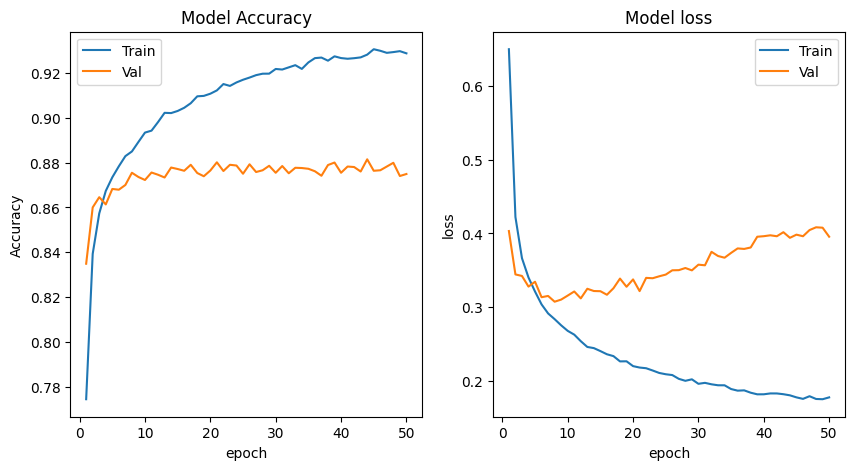

In [24]:
learning_curve(history, 50)

In [65]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

tf.keras.backend.clear_session()

model = Sequential()
model.add(Dense(32, input_shape=(X_data_df.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                456832    
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [66]:
# 모델 체크포인트 설정
checkpoint = ModelCheckpoint('best_model_ANN_2.h5',  # 모델을 저장할 파일 이름
                             monitor='val_accuracy',  # 모니터링할 지표 (여기서는 검증 정확도)
                             save_best_only=True,  # 가장 좋은 모델만 저장
                             mode='max',  # 모니터링 지표의 최대화
                             verbose=1)  # 저장 메시지 표시


callbacks = [checkpoint]
history = model.fit(X_data_df, y_encoded, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/30


2023-10-20 15:35:52.735210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1123/1125 [============================>.] - ETA: 0s - loss: 0.6156 - accuracy: 0.7853

2023-10-20 15:36:16.060974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.83689, saving model to best_model_ANN_2.h5
1125/1125 [==============================] - 27s 19ms/step - loss: 0.6153 - accuracy: 0.7854 - val_loss: 0.3946 - val_accuracy: 0.8369
Epoch 2/30
   9/1125 [..............................] - ETA: 17s - loss: 0.4364 - accuracy: 0.8090

/opt/miniconda3/envs/tf_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1124/1125 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8452
Epoch 2: val_accuracy improved from 0.83689 to 0.85500, saving model to best_model_ANN_2.h5
1125/1125 [==============================] - 18s 16ms/step - loss: 0.3912 - accuracy: 0.8451 - val_loss: 0.3519 - val_accuracy: 0.8550
Epoch 3/30
1123/1125 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8618
Epoch 3: val_accuracy improved from 0.85500 to 0.85744, saving model to best_model_ANN_2.h5
1125/1125 [==============================] - 18s 16ms/step - loss: 0.3430 - accuracy: 0.8618 - val_loss: 0.3267 - val_accuracy: 0.8574
Epoch 4/30
1124/1125 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.8714
Epoch 4: val_accuracy improved from 0.85744 to 0.86644, saving model to best_model_ANN_2.h5
1125/1125 [==============================] - 18s 16ms/step - loss: 0.3168 - accuracy: 0.8714 - val_loss: 0.3205 - val_accuracy: 0.8664
Epoch 5/30
1122/1125 [==============

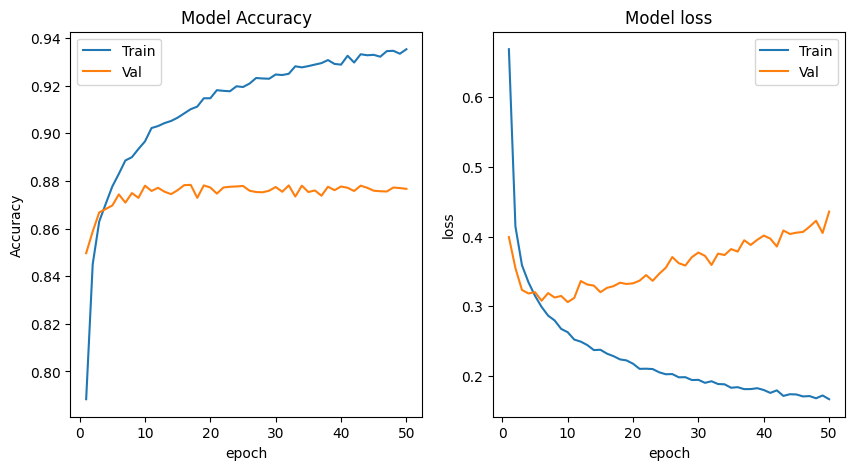

In [41]:
learning_curve(history, 50)

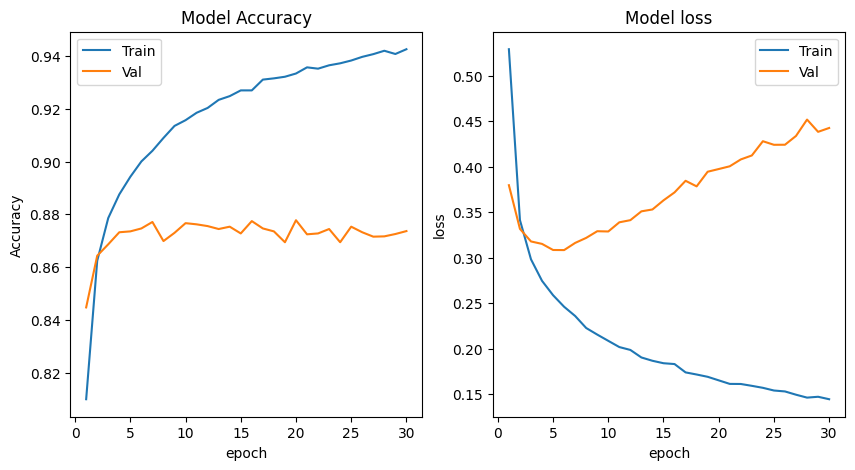

In [51]:
learning_curve(history, 30)

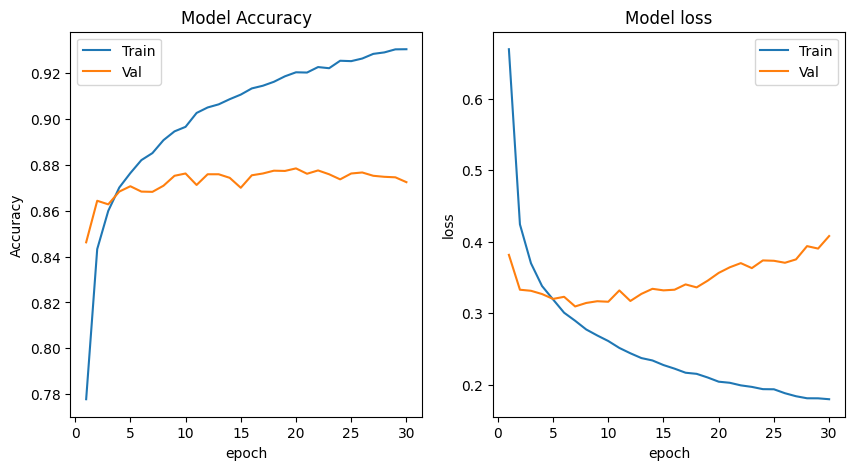

In [56]:
learning_curve(history, 30)

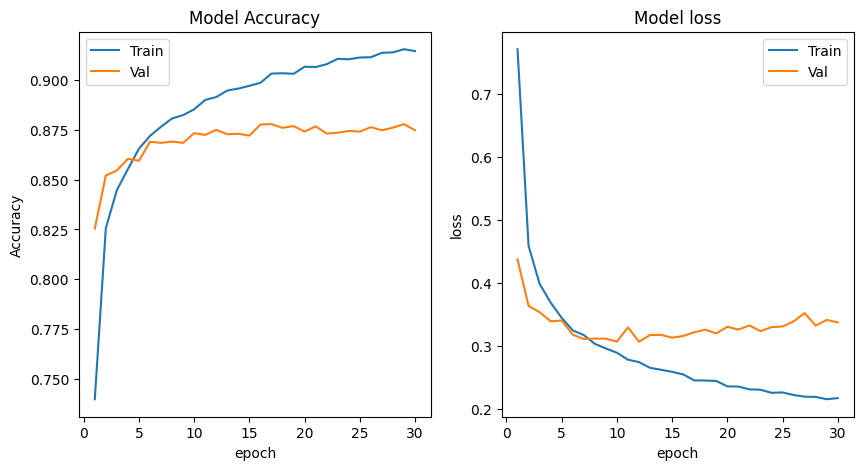

In [60]:
learning_curve(history, 30)

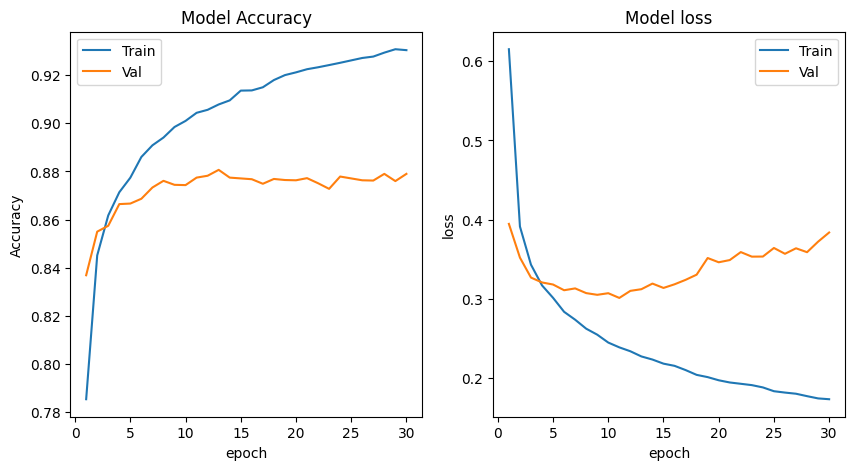

In [67]:
learning_curve(history, 30)

In [25]:
predict_df = pd.read_csv('학습셋_A트랙/A Track 예선 문제.csv')

In [26]:
predict_df['decoded_payload'] = predict_df['payload'].apply(lambda x: parse.unquote(x))

In [27]:
predict_df = create_feature_length(predict_df)
predict_df = create_feature_nonprintable(predict_df)
predict_df = create_feature_punchualchar(predict_df)
predict_df = create_feature_minbyte(predict_df)
predict_df = create_feature_maxbyte(predict_df)
predict_df = create_feature_meanbyte(predict_df)
predict_df = create_feature_stdbyte(predict_df)
predict_df = create_feature_dstbyte(predict_df)
predict_df = create_feature_sql_keywords(predict_df)
predict_df = create_feature_javascript_keywords(predict_df)
custom_predict_df = predict_df.drop(['payload', 'decoded_payload', 'Log_Number'], axis=1)
custom_predict_df.head()

,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-byte,sql-keywords,js-keywords
0,274,0,57,32,122,88.262774,28.114669,55,6,4
1,253,0,43,32,122,89.715415,27.191279,54,5,4
2,356,0,84,32,122,86.592697,28.470364,70,7,5
3,586,0,110,32,122,90.979522,26.638900,68,9,6
4,550,0,147,32,125,83.350909,27.553758,66,5,7


In [28]:
predict_df_transformed = vectorizer.transform(predict_df['decoded_payload'])

print(predict_df_transformed.shape, predict_df_transformed.shape)

# predict_df_transformed을 DataFrame으로 변환
final_predict_df = pd.DataFrame(predict_df_transformed.toarray())

(9977, 7127) (9977, 7127)


In [29]:
X_predict_df = predict_df.drop(columns=['payload', 'decoded_payload', 'Log_Number'], axis=1)

In [30]:
X_custom_predict = pd.DataFrame(scaler.transform(X_predict_df), columns=X_predict_df.columns)

In [31]:
X_predict_df = pd.concat([final_predict_df, X_custom_predict.iloc[final_predict_df.index]], axis=1)

In [68]:
y_pred = model.predict(X_predict_df)
y_pred_classes = np.argmax(y_pred, axis=1)

2023-10-20 15:49:28.201986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


312/312 [==============================] - 3s 5ms/step


In [43]:
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

In [69]:
submission = pd.read_csv('./학습셋_A트랙/A Track 예선.csv')

In [70]:
submission['label_action'] = y_pred_original

In [71]:
submission.to_csv('submission_ANN_과적합개선_2.csv', index=False)

In [72]:
best_submission = pd.read_csv('submission_ANN_BN_DO.csv')
compare_submission_1 = pd.read_csv('submission_ANN_과적합개선.csv')
compare_submission_2 = pd.read_csv('submission_ANN_과적합개선_2.csv')

In [74]:
# 'best_submission'과 'compare_submission_1' 간의 차이 계산
diff_1 = best_submission['label_action'] != compare_submission_1['label_action']
num_diff_1 = diff_1.sum()
percent_diff_1 = (num_diff_1 / len(best_submission)) * 100

# 'best_submission'과 'compare_submission_2' 간의 차이 계산
diff_2 = best_submission['label_action'] != compare_submission_2['label_action']
num_diff_2 = diff_2.sum()
percent_diff_2 = (num_diff_2 / len(best_submission)) * 100

# 결과 출력
print(f"차이가 있는 데이터 개수 (compare_submission_1): {num_diff_1}")
print(f"차이가 있는 데이터 비율 (compare_submission_1): {percent_diff_1:.2f}%")

print(f"차이가 있는 데이터 개수 (compare_submission_2): {num_diff_2}")
print(f"차이가 있는 데이터 비율 (compare_submission_2): {percent_diff_2:.2f}%")


차이가 있는 데이터 개수 (compare_submission_1): 472
차이가 있는 데이터 비율 (compare_submission_1): 4.73%
차이가 있는 데이터 개수 (compare_submission_2): 472
차이가 있는 데이터 비율 (compare_submission_2): 4.73%
